# CAUSAL HMM 

# DeepIDS Torch Implem

In [2]:
import os
import random
import gc
import warnings 
warnings.filterwarnings('ignore') 
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    device = "cuda"
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

else:
    print("No GPU available. Training will run on CPU.")
    device = "cpu"

def set_seed(seed):
    random.seed(seed)  
    np.random.seed(seed)  
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False  

set_seed(seed=12345)

GPU: NVIDIA GeForce GTX 1660 Ti is available.
torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [3]:
import pandas as pd

In [4]:
data = pd.read_csv("_data_/KDDCup_OHE_.csv")
data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_2,flag_3,flag_4,flag_5,flag_6,flag_7,flag_8,flag_9,flag_10,flag_11
0,0.0,181.0,5450.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,239.0,486.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,235.0,1337.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,219.0,1337.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,217.0,2032.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics  
from sklearn.metrics import f1_score, roc_auc_score
from torch.utils.data import TensorDataset

In [6]:
df = data.copy()

In [7]:
class DeepIDS(nn.Module):
    def __init__(self, input_dim):
        super(DeepIDS, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc_out = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.fc_out(x)
        x = self.sigmoid(x)  
        return x

In [25]:
# data sample
X = df.drop(['Y'],axis=1).values
y = df['Y'].astype(int).values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

# Implement DeepIDS arch in pytorch
class DeepIDS(nn.Module):
    def __init__(self, input_dim):
        super(DeepIDS, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4096)
        self.bn1 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc_out = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.bn3(x)
        x = self.fc_out(x)
        x = self.sigmoid(x)  
        return x

# Dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1) 
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model, Loss, Optimizer
input_dim = X_train.shape[1]  
model = DeepIDS(input_dim)
criterion = nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

# Training Loop
num_epochs = 10  
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  

        optimizer.zero_grad()  
        outputs = model(X_batch)  
        loss = criterion(outputs, y_batch)  
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Test the model with ROCAUC and F1

model.eval()
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)  
        y_batch = y_batch.to(device)

        outputs = model(X_batch)  
        prob = outputs.cpu().numpy().flatten() 
        preds = (prob >= 0.5).astype(int) 
        
        y_true.extend(y_batch.cpu().numpy().flatten())
        y_pred.extend(preds)
        y_scores.extend(prob)

f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)

print(f"[i] F1 Score: {f1:.4f}")
print(f"[î] ROC AUC Score: {roc_auc:.4f}")

Epoch [1/10], Loss: 0.0205
Epoch [2/10], Loss: 0.0105
Epoch [3/10], Loss: 0.0088
Epoch [4/10], Loss: 0.0075
Epoch [5/10], Loss: 0.0065
Epoch [6/10], Loss: 0.0062
Epoch [7/10], Loss: 0.0056
Epoch [8/10], Loss: 0.0050
Epoch [9/10], Loss: 0.0046
Epoch [10/10], Loss: 0.0044
Training complete!
[i] F1 Score: 0.9986
[î] ROC AUC Score: 0.9986


In [26]:
torch.save(model.state_dict(), "_weights_/_Pytorch_DeepIDS_.pth")

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [59]:
# Compute L2 Distribution

"""
Z -> protocol_type_1-2-3
"""

# vectorize
adf = pd.DataFrame()

# assign SCM values
x = list(df.iloc[:, list(range(0, 38)) + list(range(42, df.shape[1]))].columns)
z = list(df.iloc[:, 39:42].columns)

# insert
adf['X'] = df[x].values.tolist()
adf['Z'] = df[z].values.tolist()
adf['Y'] = df['Y'].astype(int).values

# check
adf.head()

,X,Z,Y
0,"[0.0, 2.610417637400702e-07, 0.001057130021949...","[0.0, 1.0, 0.0]",0
1,"[0.0, 3.4469050571202646e-07, 9.42688423243049...","[0.0, 1.0, 0.0]",0
2,"[0.0, 3.389216269553398e-07, 0.000259336300797...","[0.0, 1.0, 0.0]",0
3,"[0.0, 3.1584611192859326e-07, 0.00025933630079...","[0.0, 1.0, 0.0]",0
4,"[0.0, 3.1296167255024996e-07, 0.00039414462469...","[0.0, 1.0, 0.0]",0


In [60]:
# setup
X = np.stack(adf['X'].values) 
Z = np.stack(adf['Z'].values) 
Y = adf['Y'].values 

# Utils for P(Y|x,z)
model = LogisticRegression(random_state=42)
model.fit(np.hstack((X, Z)), Y, )

# Utils for P(Y|do(X=x))
def compute_do_prob(x_val, df, model):
    Z = np.stack(df['Z'].values) 
    X_z_combined = np.hstack((np.repeat([x_val], len(Z), axis=0), Z))
    P_Y_given_x_Z = model.predict_proba(X_z_combined)[:, 1]
    unique_Z, counts = np.unique(Z, axis=0, return_counts=True)
    P_Z = counts / len(Z)  
    P_Y_do_x = np.sum([P_Y_given_x_Z[i] * P_Z[i] for i in range(len(P_Z))])
    return P_Y_do_x

# create identify matrix for each signal such that X(target)=x and X(non-target)=0 
signals_id = np.identity(len(list(df.iloc[:, list(range(0, 38)) + list(range(42, df.shape[1]))].columns)))
signals_id = pd.DataFrame(signals_id)
signals_id.columns = x
signals_id.index = x

In [61]:
# Compute P(Y|do(X=x))
doxl = []

for index, row in signals_id.iterrows():
    x_val = np.array(row)
    P_Y_do_x = compute_do_prob(x_val, adf, model)
    doxl.append(P_Y_do_x)

doXdf = pd.DataFrame()
doXdf['X'] = x
doXdf['doX'] = doxl
doXdf.head()

,X,doX
0,duration,0.006730
1,src_bytes,0.008625
2,dst_bytes,0.098261
3,land,0.008870
4,wrong_fragment,0.999914


In [62]:
# compute standard-error & confidence interval .95

lci1 = []
lci2 = []

for x in list(df.columns)[:-4] : 
    se = df[[x]].std() / np.sqrt(len(df[x]))
    mu = df[[x]].mean()
    ci1 = mu - 2 * se
    ci2 = mu + 2 * se
    lci1.append(ci1[0])
    lci2.append(ci2[0])

doXdf['Ci1'] = lci1
doXdf['Ci2'] = lci2

l = []
u = []

for index, row in doXdf.iterrows():

    d = row['doX']
    low = row['doX'] + row['Ci1']
    upp = row['doX'] + row['Ci2']

    l.append(low)
    u.append(upp)

doXdf['Ci1'] = l
doXdf['Ci2'] = u
doXdf.head()

,X,doX,Ci1,Ci2
0,duration,0.006730,0.007518,0.007587
1,src_bytes,0.008625,0.008626,0.008634
2,dst_bytes,0.098261,0.098411,0.098447
3,land,0.008870,0.008896,0.008933
4,wrong_fragment,0.999914,1.001930,1.002186


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

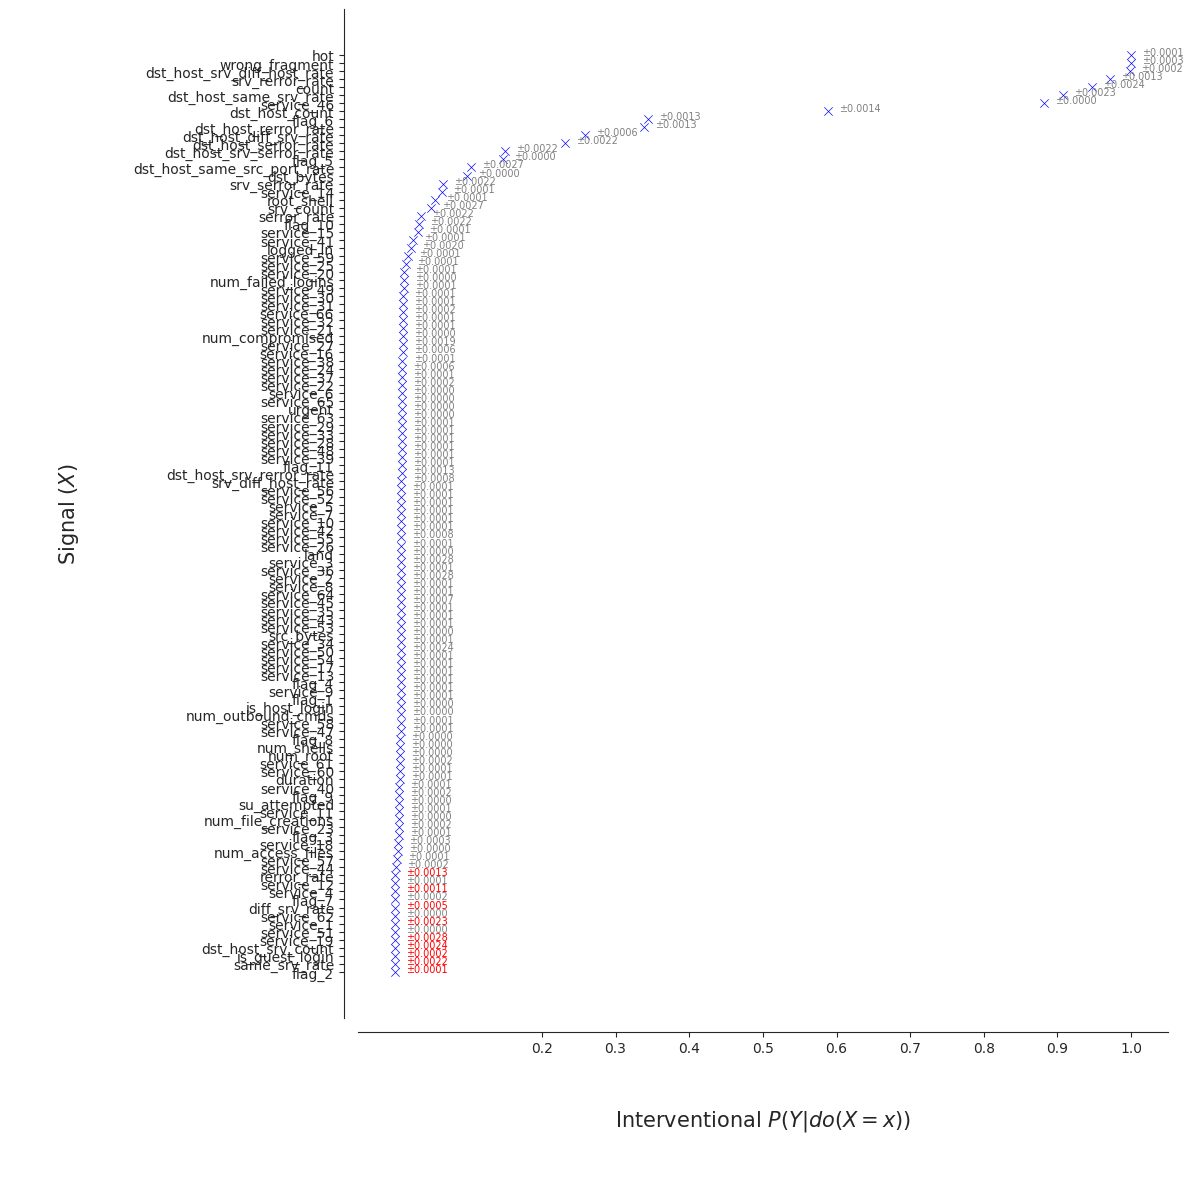

In [65]:
# Plot the DoX and CI values 
plt.figure(figsize=(12, 12))

# sort for better read
sorted_df = doXdf.sort_values(by=['doX'], ascending=False)

# plot values
g = sns.scatterplot(data=sorted_df, x="doX", y="X", marker='x', alpha=1, color='blue')

# plot error range
for idx, row in doXdf.iterrows():
    error_value = row['Ci2'] - row['Ci1']
    if error_value >= row['doX']*0.95:
        c='red'
    else:
        c='grey'
    plt.text(row['doX'] + 0.015, row['X'], f'±{error_value:.4f}', fontsize=7, color=c)

# setup ax labels and title

sns.set_style("ticks")
sns.despine(top=True, right=True, offset=10)
plt.ylabel("\n\nSignal ($X$)\n\n", fontsize=15)
plt.xlabel("\n\nInterventional $P(Y|do(X=x))$\n\n", fontsize=15)
plt.xticks(ticks=np.linspace(0.2, 1, num=9))

#sns.despine(bottom=True, left=True)
#save plot
plt.draw()
#plt.savefig('Figures/FIG1_PYDOX_TXTERR.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [11]:
from sklearn import preprocessing

In [12]:
df2 = df.copy()

In [13]:
df2

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_2,flag_3,flag_4,flag_5,flag_6,flag_7,flag_8,flag_9,flag_10,flag_11
0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0.0,4.470881e-07,0.000365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494016,0.0,4.067060e-07,0.000443,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494017,0.0,2.927706e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
494018,0.0,4.196859e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
list(df.iloc[:, list(range(0, 39)) + list(range(42, df.shape[1]))].columns)

['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Y',
 'service_1',
 'service_2',
 'service_3',
 'service_4',
 'service_5',
 'service_6',
 'service_7',
 'service_8',
 'service_9',
 'service_10',
 'service_11',
 'service_12',
 'service_13',
 'service_14',
 'service_15',
 'service_16',
 'service_17',
 'service_18',
 's

In [75]:
# 1. Compute P(X=0, Y=0) for each X
#x = list(df.iloc[:, list(range(0, 38)) + list(range(42, df.shape[1]))].columns)
#z = list(df.iloc[:, 39:42].columns)

# very slow code, to be improved
P_X0_Y0 = []

for x in list(df2.iloc[:, list(range(0, 38)) + list(range(42, df.shape[1]))].columns):
    c = 0
    l = 0
    for index, row in df2.iterrows():
        if row[x] == 0 and row['Y'] == 0:
            c += 1
        if row['Y'] == 0:
            l += 1
    P_X0_Y0.append(c/l)

doXdf['P_X0_Y0'] = P_X0_Y0

# 2. Compute numerator for non 0 relative denominator
l3 = []
for index, row in doXdf.iterrows():
    if row['P_X0_Y0'] > 0 :
        i = row['doX'] * row['P_X0_Y0']
    else:
        i = 0
    l3.append(i)

doXdf['P_Y1_DX1'] = l3
doXdf.head()

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1
0,duration,0.006730,0.007518,0.007587,0.879828,0.005921
1,src_bytes,0.008625,0.008626,0.008634,0.056807,0.000490
2,dst_bytes,0.098261,0.098411,0.098447,0.145923,0.014339
3,land,0.008870,0.008896,0.008933,0.999990,0.008870
4,wrong_fragment,0.999914,1.001930,1.002186,1.000000,0.999914


In [15]:
doXdf = pd.read_csv('_data_/doXdf_deepIDS_.csv')
doXdf.head()
#doXdf.to_csv('_data_/doXdf_deepIDS_.csv', index=False)

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1
0,duration,0.006730,0.007518,0.007587,0.879828,0.005921
1,src_bytes,0.008625,0.008626,0.008634,0.056807,0.000490
2,dst_bytes,0.098261,0.098411,0.098447,0.145923,0.014339
3,land,0.008870,0.008896,0.008933,0.999990,0.008870
4,wrong_fragment,0.999914,1.001930,1.002186,1.000000,0.999914


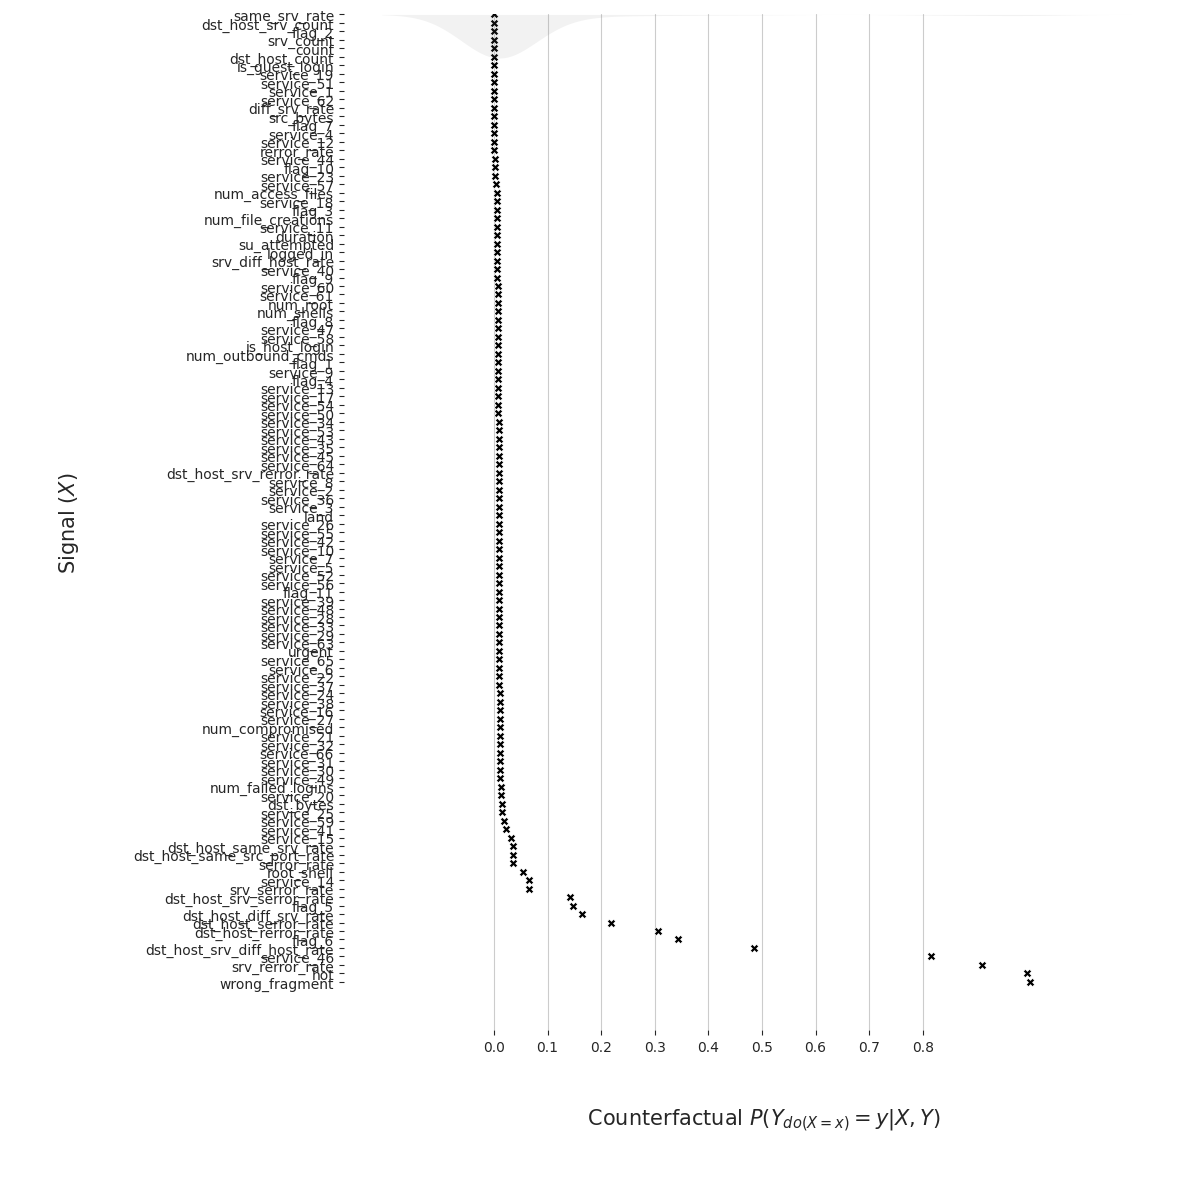

In [77]:
plt.figure(figsize=(12, 12))
plt.grid(axis='x')

# sort for better read
sorted_df = doXdf.sort_values(by=['P_Y1_DX1'], ascending=True)

# plot values
sns.scatterplot(data=sorted_df, y='X', x='P_Y1_DX1', color='black', marker='X', zorder=1) 

sns.kdeplot(data=doXdf['P_Y1_DX1'], 
            color='grey', 
            linewidth=0, 
            alpha=0.1, 
            fill=True,
            zorder=2)

# setup ax labels and title
plt.ylabel("\n\nSignal ($X$)\n\n", fontsize=15)
plt.xlabel("\n\n Counterfactual $P(Y_{do(X=x)} = y | X , Y)$ \n\n", fontsize=15)
plt.xticks(ticks=np.linspace(0, 0.8, num=9))
plt.yticks(size=10)
sns.despine(bottom=True, left=True)

#save plot
plt.draw()
#plt.savefig('Figures/FIG3_PYYDOXX_COUNTERFACTUAL.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [88]:
import shap

In [85]:
input_dim = X_test.shape[1] 
model = DeepIDS(input_dim)
model.load_state_dict(torch.load("_weights_/_Pytorch_DeepIDS_.pth"))
model.to(device)
model.eval()

DeepIDS(
  (fc1): Linear(in_features=118, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [94]:
from tqdm import tqdm  # Progress bar

In [ ]:
# Load trained model
#model = DeepIDS(input_dim=X_train.shape[1]).to(device)
#model.load_state_dict(torch.load("_weights_/_Pytorch_DeepIDS_.pth"))
#model.eval()

# Define a function for SHAP to call
def model_predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(data_tensor).cpu().numpy()
    return output

#X_test_np = X_test_tensor.cpu().numpy()  # Ensure NumPy format for SHAP
#sl_dnn_explainer = shap.Explainer(model_predict, X_test_np)
#sl_dnn_shap_values = sl_dnn_explainer(X_test_np)
#shap.summary_plot(sl_dnn_shap_values, X_test_np)

num_samples = 1000
X_sample = X_test_tensor[:num_samples].to(device)
explainer = shap.GradientExplainer(model, X_sample)
shap_values = explainer.shap_values(X_sample)

In [115]:
shap_values.shape

(1000, 118, 1)

In [119]:
shap_v = shap_values.mean(axis=0).squeeze()
shap_v = shap_v[:118]
n = df.iloc[:, list(range(0, 38)) + list(range(39, df.shape[1]))].columns 
if len(shap_v) != len(n):
    print(f"Mismatch: SHAP values ({len(shap_v)}) vs Features ({len(n)})")
else:
    # Create a DataFrame
    rdf = pd.DataFrame({'Feature': n, 'SHAP': shap_v})
    print(rdf.head())

          Feature      SHAP
0        duration  0.000736
1       src_bytes -0.008561
2       dst_bytes  0.015425
3            land  0.000000
4  wrong_fragment  0.000005


In [129]:
#rdf = rdf.drop(index=range(38, 41)).reset_index(drop=True)
rdf.head()

,Feature,SHAP
0,duration,0.000736
1,src_bytes,-0.008561
2,dst_bytes,0.015425
3,land,0.000000
4,wrong_fragment,0.000005


In [132]:
#
# MODIFIED - NOW WE USE THE SQUARED DISTANCE WITH LOG
#

# Top N values returned are the candidates
rdf['doX'] = doXdf['doX']
lm = []

def sigmoid(x, alpha=1):
    return 1 / (1 + np.exp(-alpha * x))

for index, row in rdf.iterrows():
    phi_x = row['SHAP']
    P_Y_do_X = row['doX'] 
    phi_scaled = sigmoid(phi_x)
    w = (P_Y_do_X - phi_scaled) ** 2 
    lm.append(w)

rdf['W_X']=lm
rdf.sort_values(by="W_X", ascending=False).head()

,Feature,SHAP,doX,W_X
105,flag_2,0.000091,1.644615e-07,0.250023
25,same_srv_rate,0.000059,4.069909e-06,0.250011
6,hot,0.000001,1.000000e+00,0.250000
18,is_guest_login,0.000000,2.920120e-05,0.249971
56,service_19,0.000000,6.232653e-05,0.249938


In [16]:
rdf = pd.read_csv('_data_/_WeightFunctionv2_DeepIDS_TragetFeatures_.csv')
#rdf.to_csv('_data_/_WeightFunctionv2_DeepIDS_TragetFeatures_.csv', index=False)

In [17]:
from mpl_toolkits.mplot3d import Axes3D

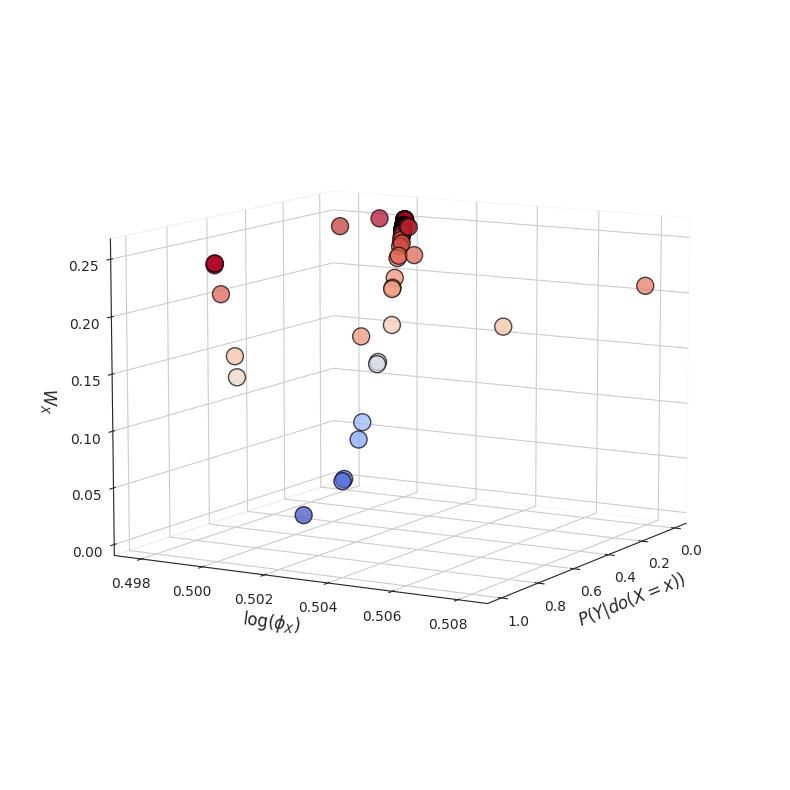

In [140]:
P_Y_do_X = rdf['doX']
phi_X = rdf['SHAP']
feature_names = rdf['Feature'] 
phi_scaled = sigmoid(phi_X)
w = (P_Y_do_X - phi_scaled) ** 2  

k = 3 
top_k_indices = np.argsort(w)[-k:] 

# Create Fig
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_facecolor('white')
ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True

ax.xaxis.pane.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax.yaxis.pane.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax.zaxis.pane.set_facecolor((1.0, 1.0, 1.0, 1.0))

scatter = ax.scatter(
    P_Y_do_X, phi_scaled, w, 
    c=w, cmap='coolwarm', 
    edgecolor='k', alpha=.7, s=150
)

# Add labels with feature names for top k points
#for i in top_k_indices:
#    ax.text(P_Y_do_X.iloc[i]-0.05, phi_scaled.iloc[i], w.iloc[i],  
#            feature_names.iloc[i], 
#            color='black', fontsize=8, fontweight='bold')

# Adjust view
ax.view_init(elev=10, azim=30)

# Labels & appearance
ax.set_xlabel(r'$P(Y | do(X=x))$', fontsize=12, labelpad=10)
ax.set_ylabel(r'log' + r'$(\phi_X)$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$W_X$', fontsize=12, labelpad=10)
ax.set_box_aspect(None, zoom=0.85)
ax.tick_params(axis='both', which='major', labelsize=10, pad=5)
ax.grid(True)

plt.tight_layout()
fig.savefig("_Figures_/_DeepIDS_SpuriousTargets_.png", dpi=300, bbox_inches='tight', transparent=True)  # Save as high-quality PNG
plt.show()

In [18]:
rdf = rdf.rename(columns={'W_X': 'Mean'}) # lazy
rdf.head()

,Feature,SHAP,doX,Mean
0,duration,0.000736,0.006730,0.243497
1,src_bytes,-0.008561,0.008625,0.239350
2,dst_bytes,0.015425,0.098261,0.164508
3,land,0.000000,0.008870,0.241209
4,wrong_fragment,0.000005,0.999914,0.249912


In [19]:
import random
from pandas.testing import assert_frame_equal

In [59]:
# Suffle for spur_candidates

rdf = rdf.sort_values(by='Mean', ascending=False) # Change ascend mode
rdf.reset_index(inplace=True, drop=True)

spur_candidate = []

for index, row in rdf.iterrows():
    if index < 120: # 5
        spur_candidate.append(row['Feature'])
        
print(f'\n[i] Spurious Candidates :      {spur_candidate}')

# Shuffle 
sdf = df.copy()

for f in spur_candidate:
    tdf = list(sdf[f])
    i = 1
    while i < 3: # probably to much
        random.shuffle(tdf)
        i+=1
    sdf[f] = tdf

# Check false - we randomized effectively
if df.equals(sdf) == False:
    print(f'[+] Finished!\n')


[i] Spurious Candidates :      ['flag_2', 'same_srv_rate', 'hot', 'is_guest_login', 'service_19', 'wrong_fragment', 'service_51', 'service_1', 'service_62', 'diff_srv_rate', 'flag_7', 'service_4', 'service_12', 'dst_host_srv_count', 'rerror_rate', 'service_44', 'dst_host_srv_diff_host_rate', 'service_57', 'num_access_files', 'service_18', 'service_23', 'flag_3', 'num_file_creations', 'service_11', 'su_attempted', 'flag_9', 'service_40', 'duration', 'service_60', 'service_61', 'num_root', 'num_shells', 'flag_8', 'service_47', 'service_58', 'is_host_login', 'num_outbound_cmds', 'flag_1', 'service_9', 'flag_4', 'service_13', 'service_17', 'service_54', 'service_50', 'service_34', 'service_53', 'service_43', 'service_35', 'service_45', 'service_64', 'service_8', 'service_2', 'service_36', 'service_3', 'land', 'service_26', 'service_55', 'service_42', 'service_10', 'service_7', 'service_5', 'service_52', 'service_56', 'srv_diff_host_rate', 'dst_host_srv_rerror_rate', 'flag_11', 'service_39

In [56]:
# Convert data to tensors
def prepare_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

# Define training function
def train_deepids(model, train_loader, num_epochs=3, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Prepare biased dataset
X_biased = df.drop(['Y'], axis=1).values
y_biased = df['Y'].astype(int).values
X_train_biased, X_test_biased, y_train_biased, y_test_biased = prepare_data(X_biased, y_biased)

# Prepare shuffled dataset
X_shuf = sdf.drop(['Y'], axis=1).values
y_shuf = sdf['Y'].astype(int).values
X_train_shuf, X_test_shuf, y_train_shuf, y_test_shuf = prepare_data(X_shuf, y_shuf)

# Create DataLoaders
batch_size = 64
train_dataset_biased = torch.utils.data.TensorDataset(X_train_biased, y_train_biased)
train_loader_biased = torch.utils.data.DataLoader(train_dataset_biased, batch_size=batch_size, shuffle=True)

train_dataset_shuf = torch.utils.data.TensorDataset(X_train_shuf, y_train_shuf)
train_loader_shuf = torch.utils.data.DataLoader(train_dataset_shuf, batch_size=batch_size, shuffle=True)

# Initialize models
input_dim = X_biased.shape[1]  # Number of features
def_deepids = DeepIDS(input_dim)
shuf_deepids = DeepIDS(input_dim)

# Train models
print("\nTraining VANILLA DeepIDS...")
train_deepids(def_deepids, train_loader_biased)

print("\nTraining CAUSAL DeepIDS...")
train_deepids(shuf_deepids, train_loader_shuf)

# Evaluate models
def_deepids.eval()
shuf_deepids.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_test_shuf = X_test_shuf.to(device)
y_test_shuf = y_test_shuf.to(device)

with torch.no_grad():
    def_y_pred = (def_deepids(X_test_shuf).cpu().numpy() > 0.5).astype(int)
    shuf_y_pred = (shuf_deepids(X_test_shuf).cpu().numpy() > 0.5).astype(int)

# Check performance
print(f'\n====== CAUSAL DeepIDS ======\n')
print(f'F1        : {metrics.f1_score(y_test_shuf.cpu(), shuf_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test_shuf.cpu(), shuf_y_pred)}')

print(f'\n====== VANILLA DeepIDS ======\n')
print(f'F1        : {metrics.f1_score(y_test_shuf.cpu(), def_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test_shuf.cpu(), def_y_pred)}')


Training VANILLA DeepIDS...
Epoch 1/3, Loss: 73.4159
Epoch 2/3, Loss: 46.4525
Epoch 3/3, Loss: 32.5467

Training CAUSAL DeepIDS...
Epoch 1/3, Loss: 195.0983
Epoch 2/3, Loss: 122.6447
Epoch 3/3, Loss: 107.8366

====== CAUSAL DeepIDS ======

F1        : 0.9939788757211756
ROC-AUC   : 0.9815725533861872

====== VANILLA DeepIDS ======

F1        : 0.9212914206691133
ROC-AUC   : 0.8899432317311159


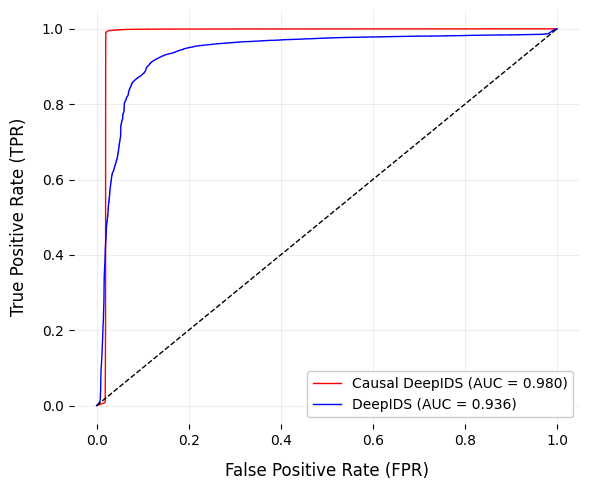

In [68]:
# Get raw prediction scores (not thresholded)
with torch.no_grad():
    def_y_score = def_deepids(X_test_shuf).cpu().numpy()
    shuf_y_score = shuf_deepids(X_test_shuf).cpu().numpy()

# Compute ROC curves
fpr_def, tpr_def, _ = roc_curve(y_test_shuf.cpu(), def_y_score)
fpr_shuf, tpr_shuf, _ = roc_curve(y_test_shuf.cpu(), shuf_y_score)

# Compute AUC
auc_def = auc(fpr_def, tpr_def)
auc_shuf = auc(fpr_shuf, tpr_shuf)

# Create figure
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_facecolor('white')  # White background

# Plot ROC Curves
ax.plot(fpr_shuf, tpr_shuf, color='red', label=f'Causal DeepIDS (AUC = {auc_shuf:.3f})', linewidth=1)
ax.plot(fpr_def, tpr_def, color='blue', label=f'DeepIDS (AUC = {auc_def:.3f})', linewidth=1)

# Confidence Intervals (if multiple runs are available)
std_tpr_shuf = sem(tpr_shuf) if len(tpr_shuf) > 1 else 0
std_tpr_def = sem(tpr_def) if len(tpr_def) > 1 else 0

#ax.fill_between(fpr_shuf, tpr_shuf - std_tpr_shuf, tpr_shuf + std_tpr_shuf, color='red', alpha=0.2)
#ax.fill_between(fpr_def, tpr_def - std_tpr_def, tpr_def + std_tpr_def, color='blue', alpha=0.2)

# Random baseline
ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', linewidth=1)

# Labels & Styling
ax.set_xlabel("False Positive Rate (FPR)", fontsize=12, labelpad=10)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=12, labelpad=10)

# Grid and Spines
ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)
for spine in ax.spines.values():
    spine.set_visible(False)  # Remove plot borders

# Legend
ax.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)

# Show & Save Plot
plt.savefig('_Figures_/_DeepIDS_vs_DeepCausalityIDS_.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()